In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import ast
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from scipy import stats as st
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import time

In [12]:
spectrum_len = 500 # automate this
data_dir = os.environ['DATA_DIR']
parent_dir = os.environ['PWD']
stddata_path = os.path.join(data_dir, "StdData-" + str(spectrum_len))
plots_dir = os.path.join(data_dir, "plots-" + str(spectrum_len))
os.chdir(os.path.join(parent_dir, "lab-notebook", "smunukutla"))

In [13]:
img = mpimg.imread(os.path.join(plots_dir, os.listdir(plots_dir)[0]))
spectrum_height = img.shape[0]
spectrum_width = img.shape[1]

In [14]:
def convertimg(img):
    newimg = np.empty([img.shape[0], img.shape[1]])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            row = img[i][j]
            newimg[i][j] = (row[0] + row[1] + row[2])/3
    return newimg

In [15]:
data = pd.read_csv("data.csv", sep=",")
record_nums = data.iloc[0, :].tolist()
spectrum_names = data.iloc[1, :].tolist()
y = data.iloc[2, :].astype(int).tolist()
y = np.reshape(y, (len(y), 1))
num_samples = len(y)

In [16]:
start_time = time.time()
spectra = np.zeros((num_samples, spectrum_height, spectrum_width))
i = 0
for num in record_nums:
    img = plt.imread(os.path.join(plots_dir, num + "-" + spectrum_names[i] + ".png")) # look into timeit, pickle file
    spectra[i] = convertimg(img)
    i += 1

end_time = time.time()
print(end_time - start_time)

52.240920066833496


In [17]:
spectra = spectra.reshape(spectra.shape[0], spectra.shape[1], spectra.shape[2], 1)
spectra.shape

(166, 216, 324, 1)

In [18]:
y_cat = to_categorical(y)

In [19]:
spectra[[0, 1], :].shape

(2, 216, 324, 1)

In [20]:
# fi = open("indices.txt", "r")
# num_runs = int(fi.readline())
# num_minerals = int(fi.readline())

# stats = []

# for i in range(num_runs):
#     train_set_indices = ast.literal_eval(fi.readline())
#     test_set_indices = ast.literal_eval(fi.readline())
#     dev_set_indices = ast.literal_eval(fi.readline())

#     for j in train_set_indices:
#         j = int(j)
#     for k in test_set_indices:
#         k = int(k)
#     for m in dev_set_indices:
#         m = int(m)
    
#     train_set = spectra[train_set_indices, :]
#     dev_set = spectra[dev_set_indices, :]
#     test_set = spectra[test_set_indices, :]
    
#     train_labels = y_cat[train_set_indices, :]
#     dev_labels = y_cat[dev_set_indices, :]
#     test_labels = y_cat[test_set_indices, :]
    
#     model = Sequential()
#     #add model layers
#     model.add(Conv2D(32, kernel_size=10, strides=(6,6), activation='relu', input_shape=(spectra.shape[1],spectra.shape[2], 1))) # finer features at the first layer
#     model.add(Conv2D(32, kernel_size=3, activation='relu')) # larger features at later layer
#     model.add(Flatten())
    
#     from tensorflow.keras import backend as K

#     # with a Sequential model
#     get_3rd_layer_output = K.function([model.layers[0].input],
#                                       [model.layers[3].output])
#     layer_output = get_3rd_layer_output(dev_set)
    
#     clf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='entropy')
    
#     # clf.fit(train_set, train_labels)
#     clf.fit(train_set, train_labels)
    
#     # preds = clf.predict(test_set)
#     # print("Accuracy:", accuracy_score(test_labels, preds))
#     preds = clf.predict(test_set)
# #     print("Accuracy:", accuracy_score(y_test, preds))
#     stats.append(accuracy_score(test_labels, preds))

# print("2D CNN + Random Forest Results:", st.describe(stats))

In [22]:
fi = open("indices.txt", "r")
num_runs = int(fi.readline())
num_minerals = int(fi.readline())

combo_stats = []
cnn_stats = []

init_time = time.time()

for i in range(10):
    train_set_indices = ast.literal_eval(fi.readline())
    test_set_indices = ast.literal_eval(fi.readline())
    dev_set_indices = ast.literal_eval(fi.readline())

    for j in train_set_indices:
        j = int(j)
    for k in test_set_indices:
        k = int(k)
    for m in dev_set_indices:
        m = int(m)
        
#     print(train_set_indices)
#     print(test_set_indices)
#     print(dev_set_indices)
    
    train_set = spectra[train_set_indices, :]
    train_labels = y_cat[train_set_indices, :]
    dev_set = spectra[dev_set_indices, :]
    dev_labels = y_cat[dev_set_indices, :]
    test_set = spectra[test_set_indices, :]
    test_labels = y_cat[test_set_indices, :]
    
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size=7, strides=(5,5), activation='relu', input_shape=(spectra.shape[1],spectra.shape[2], 1))) # finer features at the first layer
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=3, activation='relu')) # larger features at later layer
#     model.add(Conv2D(32, kernel_size=3, activation='relu'))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(num_minerals*5, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Flatten())
#     model.add(Dense(num_minerals*5, activation='relu'))
    
    model.add(Dense(num_minerals, activation='softmax'))
#     model.summary()
    
    flatten_ind = 3
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    BATCH_SIZE = 32
    EPOCHS = 20
    
#     checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
#     tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)
    
#     history = model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_data=(dev_set, dev_labels), callbacks=[checkpointer, tensorboard, EarlyStopping(monitor='val_acc', patience=5)]).history
    model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_data=(dev_set, dev_labels))
    
    FC_layer_model = Model(inputs=model.input, outputs=model.get_layer(index=flatten_ind).output)
#     FC_layer_model.summary()
#     print(model.input.shape)
#     print(model.get_layer(index=flatten_ind).output.shape)
    
    features = np.zeros(shape = (train_set.shape[0], model.layers[flatten_ind].output.shape[1]))
#     print(features.shape)
    for p in range(train_set.shape[0]):
        spectra_in = train_set[p]
        spectra_in = np.expand_dims(spectra_in, axis=0)
        FC_output = FC_layer_model.predict(spectra_in)
#         print(FC_output.shape)
        features[p] = FC_output
    
#     np.save('features', features)
    
    feature_col = []
    for p in range(model.layers[flatten_ind].output.shape[1]):
        feature_col.append("f_" + str(p))
    
    train_features = pd.DataFrame(data = features, columns = feature_col)
    feature_col = np.array(feature_col)
    
    train_label_ids = y[train_set_indices, :]
    train_class = list(np.unique(train_label_ids))
#     print('Training Features Shape:', train_features.shape)
#     print('Training Labels Shape:', train_label_ids.shape)
    
#     my_list = model.evaluate(test_set, test_labels, verbose=0)
    
#     stats.append(my_list[1])
    
#     print(model.layers[2].input)
#     print(model.layers[2].output.shape[1])

    clf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='entropy')
    
#     # clf.fit(train_set, train_labels)
    clf.fit(train_features, train_label_ids)
    
    features_test = np.zeros(shape = (test_set.shape[0], model.layers[flatten_ind].output.shape[1]))
    for p in range(test_set.shape[0]):
        spectra_in = test_set[p]
        spectra_in = np.expand_dims(spectra_in, axis=0)
        FC_output = FC_layer_model.predict(spectra_in)
        features_test[p] = FC_output
    
    test_features = pd.DataFrame(data = features_test, columns = feature_col)
    feature_col = np.array(feature_col)
    
    test_label_ids = y[test_set_indices, :]
    test_class = list(np.unique(test_label_ids))
#     print('Test Features Shape:', test_features.shape)
#     print('Test Labels Shape:', test_label_ids.shape)
    
    cnn_preds = model.evaluate(test_set, test_labels, verbose=0)
    combo_predictions = clf.predict(test_features)
    
#     accuracy=accuracy_score(predictions , test_label_ids)
#     print('Accuracy:', accuracy*100, '%.')
#     # preds = clf.predict(test_set)
#     # print("Accuracy:", accuracy_score(test_labels, preds))
#     preds = clf.predict(test_set)
# #     print("Accuracy:", accuracy_score(y_test, preds))
    cnn_stats.append(cnn_preds[1])
    combo_stats.append(accuracy_score(combo_predictions, test_label_ids))

print("2D CNN Results:", st.describe(cnn_stats))
print("2D CNN + RF Results:", st.describe(combo_stats))
total_seconds = time.time() - init_time
print(total_seconds)

Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 3s - loss: 2.7504 - acc: 0.1010 - val_loss: 2.2703 - val_acc: 0.0909
Epoch 2/20
99/99 - 2s - loss: 2.1860 - acc: 0.2020 - val_loss: 2.0650 - val_acc: 0.3636
Epoch 3/20
99/99 - 1s - loss: 1.9372 - acc: 0.4545 - val_loss: 2.2642 - val_acc: 0.2121
Epoch 4/20
99/99 - 1s - loss: 1.8641 - acc: 0.3636 - val_loss: 1.5826 - val_acc: 0.6061
Epoch 5/20
99/99 - 1s - loss: 1.3048 - acc: 0.6869 - val_loss: 1.2161 - val_acc: 0.6061
Epoch 6/20
99/99 - 1s - loss: 1.0126 - acc: 0.7778 - val_loss: 0.9230 - val_acc: 0.7879
Epoch 7/20
99/99 - 1s - loss: 0.6127 - acc: 0.9394 - val_loss: 1.1154 - val_acc: 0.6364
Epoch 8/20
99/99 - 1s - loss: 0.4732 - acc: 0.8687 - val_loss: 0.4733 - val_acc: 0.8788
Epoch 9/20
99/99 - 1s - loss: 0.2451 - acc: 0.9697 - val_loss: 0.3949 - val_acc: 0.9091
Epoch 10/20
99/99 - 1s - loss: 0.1708 - acc: 0.9899 - val_loss: 0.2952 - val_acc: 0.9091
Epoch 11/20
99/99 - 1s - loss: 0.1639 - acc: 0.9495 - val_loss: 0.3249 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 1s - loss: 2.4022 - acc: 0.1212 - val_loss: 2.2298 - val_acc: 0.4242
Epoch 2/20
99/99 - 1s - loss: 2.2040 - acc: 0.2929 - val_loss: 2.0825 - val_acc: 0.5152
Epoch 3/20
99/99 - 1s - loss: 2.0446 - acc: 0.5152 - val_loss: 1.9854 - val_acc: 0.4242
Epoch 4/20
99/99 - 1s - loss: 1.8768 - acc: 0.4040 - val_loss: 1.7534 - val_acc: 0.3939
Epoch 5/20
99/99 - 1s - loss: 1.5668 - acc: 0.4949 - val_loss: 1.2869 - val_acc: 0.7273
Epoch 6/20
99/99 - 1s - loss: 0.9949 - acc: 0.8990 - val_loss: 0.8796 - val_acc: 0.8182
Epoch 7/20
99/99 - 1s - loss: 0.5623 - acc: 0.9293 - val_loss: 0.5579 - val_acc: 0.8485
Epoch 8/20
99/99 - 1s - loss: 0.3278 - acc: 0.9192 - val_loss: 0.4929 - val_acc: 0.8485
Epoch 9/20
99/99 - 1s - loss: 0.2136 - acc: 0.9394 - val_loss: 0.4312 - val_acc: 0.8485
Epoch 10/20
99/99 - 1s - loss: 0.1111 - acc: 0.9899 - val_loss: 0.3434 - val_acc: 0.8788
Epoch 11/20
99/99 - 1s - loss: 0.0920 - acc: 0.9697 - val_loss: 0.3418 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 1s - loss: 3.2820 - acc: 0.1818 - val_loss: 2.3236 - val_acc: 0.3030
Epoch 2/20
99/99 - 1s - loss: 2.2739 - acc: 0.2222 - val_loss: 2.1552 - val_acc: 0.4242
Epoch 3/20
99/99 - 1s - loss: 2.0859 - acc: 0.3333 - val_loss: 1.9911 - val_acc: 0.4242
Epoch 4/20
99/99 - 1s - loss: 1.8770 - acc: 0.5354 - val_loss: 1.7791 - val_acc: 0.4545
Epoch 5/20
99/99 - 1s - loss: 1.4709 - acc: 0.6667 - val_loss: 1.4192 - val_acc: 0.6667
Epoch 6/20
99/99 - 1s - loss: 1.0888 - acc: 0.8182 - val_loss: 1.0579 - val_acc: 0.7273
Epoch 7/20
99/99 - 1s - loss: 0.6201 - acc: 0.9192 - val_loss: 0.8362 - val_acc: 0.6970
Epoch 8/20
99/99 - 1s - loss: 0.3548 - acc: 0.9091 - val_loss: 0.7881 - val_acc: 0.6667
Epoch 9/20
99/99 - 1s - loss: 0.2650 - acc: 0.9293 - val_loss: 0.5865 - val_acc: 0.7879
Epoch 10/20
99/99 - 1s - loss: 0.1773 - acc: 0.9697 - val_loss: 0.5234 - val_acc: 0.7879
Epoch 11/20
99/99 - 1s - loss: 0.1171 - acc: 0.9495 - val_loss: 0.5318 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 1s - loss: 2.6017 - acc: 0.1212 - val_loss: 2.2355 - val_acc: 0.0909
Epoch 2/20
99/99 - 1s - loss: 2.1083 - acc: 0.2525 - val_loss: 2.4850 - val_acc: 0.1515
Epoch 3/20
99/99 - 1s - loss: 2.1360 - acc: 0.2222 - val_loss: 1.7834 - val_acc: 0.3939
Epoch 4/20
99/99 - 1s - loss: 1.6039 - acc: 0.4949 - val_loss: 1.4095 - val_acc: 0.7273
Epoch 5/20
99/99 - 1s - loss: 1.0397 - acc: 0.8182 - val_loss: 1.0070 - val_acc: 0.8485
Epoch 6/20
99/99 - 1s - loss: 0.5996 - acc: 0.9192 - val_loss: 0.9796 - val_acc: 0.6061
Epoch 7/20
99/99 - 1s - loss: 0.4089 - acc: 0.8990 - val_loss: 0.5476 - val_acc: 0.8485
Epoch 8/20
99/99 - 1s - loss: 0.2092 - acc: 0.9394 - val_loss: 0.5504 - val_acc: 0.8182
Epoch 9/20
99/99 - 1s - loss: 0.1292 - acc: 0.9697 - val_loss: 0.4892 - val_acc: 0.8485
Epoch 10/20
99/99 - 1s - loss: 0.0888 - acc: 0.9798 - val_loss: 0.4873 - val_acc: 0.8485
Epoch 11/20
99/99 - 1s - loss: 0.0631 - acc: 0.9899 - val_loss: 0.5126 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 1s - loss: 2.8502 - acc: 0.1313 - val_loss: 2.4564 - val_acc: 0.1212
Epoch 2/20
99/99 - 1s - loss: 2.3217 - acc: 0.1515 - val_loss: 3.3224 - val_acc: 0.1818
Epoch 3/20
99/99 - 1s - loss: 2.7517 - acc: 0.2525 - val_loss: 2.1549 - val_acc: 0.3636
Epoch 4/20
99/99 - 1s - loss: 2.1361 - acc: 0.3535 - val_loss: 2.0110 - val_acc: 0.2424
Epoch 5/20
99/99 - 1s - loss: 1.9034 - acc: 0.3232 - val_loss: 1.8946 - val_acc: 0.4848
Epoch 6/20
99/99 - 1s - loss: 1.7114 - acc: 0.4848 - val_loss: 1.6611 - val_acc: 0.4848
Epoch 7/20
99/99 - 1s - loss: 1.3600 - acc: 0.6566 - val_loss: 1.6224 - val_acc: 0.4242
Epoch 8/20
99/99 - 1s - loss: 1.0090 - acc: 0.6465 - val_loss: 1.1074 - val_acc: 0.6364
Epoch 9/20
99/99 - 1s - loss: 0.6785 - acc: 0.8384 - val_loss: 0.8514 - val_acc: 0.7576
Epoch 10/20
99/99 - 1s - loss: 0.4437 - acc: 0.9293 - val_loss: 0.6354 - val_acc: 0.8485
Epoch 11/20
99/99 - 1s - loss: 0.2623 - acc: 0.9596 - val_loss: 0.5437 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 2s - loss: 2.8345 - acc: 0.0707 - val_loss: 2.2419 - val_acc: 0.1818
Epoch 2/20
99/99 - 1s - loss: 2.1690 - acc: 0.3434 - val_loss: 2.0985 - val_acc: 0.3939
Epoch 3/20
99/99 - 1s - loss: 2.0033 - acc: 0.3232 - val_loss: 1.8448 - val_acc: 0.6970
Epoch 4/20
99/99 - 1s - loss: 1.7559 - acc: 0.5859 - val_loss: 1.6656 - val_acc: 0.6061
Epoch 5/20
99/99 - 1s - loss: 1.4192 - acc: 0.8081 - val_loss: 1.2793 - val_acc: 0.7273
Epoch 6/20
99/99 - 1s - loss: 1.1033 - acc: 0.7273 - val_loss: 0.9974 - val_acc: 0.8182
Epoch 7/20
99/99 - 1s - loss: 0.6528 - acc: 0.9091 - val_loss: 0.9790 - val_acc: 0.6970
Epoch 8/20
99/99 - 1s - loss: 0.4574 - acc: 0.9091 - val_loss: 0.7252 - val_acc: 0.7879
Epoch 9/20
99/99 - 1s - loss: 0.3162 - acc: 0.9394 - val_loss: 0.5699 - val_acc: 0.8788
Epoch 10/20
99/99 - 1s - loss: 0.2016 - acc: 1.0000 - val_loss: 0.6279 - val_acc: 0.7879
Epoch 11/20
99/99 - 1s - loss: 0.1874 - acc: 0.9394 - val_loss: 0.5316 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 2s - loss: 2.5181 - acc: 0.0808 - val_loss: 2.2415 - val_acc: 0.3030
Epoch 2/20
99/99 - 1s - loss: 2.1946 - acc: 0.2727 - val_loss: 2.4960 - val_acc: 0.1212
Epoch 3/20
99/99 - 1s - loss: 2.1887 - acc: 0.3737 - val_loss: 2.1454 - val_acc: 0.3030
Epoch 4/20
99/99 - 1s - loss: 2.1111 - acc: 0.3434 - val_loss: 2.0333 - val_acc: 0.3030
Epoch 5/20
99/99 - 1s - loss: 1.8643 - acc: 0.4848 - val_loss: 1.9272 - val_acc: 0.4848
Epoch 6/20
99/99 - 1s - loss: 1.6275 - acc: 0.5455 - val_loss: 1.5896 - val_acc: 0.5455
Epoch 7/20
99/99 - 1s - loss: 1.1571 - acc: 0.8182 - val_loss: 1.4051 - val_acc: 0.6970
Epoch 8/20
99/99 - 1s - loss: 0.7788 - acc: 0.9596 - val_loss: 1.9475 - val_acc: 0.4242
Epoch 9/20
99/99 - 1s - loss: 0.8401 - acc: 0.7172 - val_loss: 1.1472 - val_acc: 0.7273
Epoch 10/20
99/99 - 1s - loss: 0.4728 - acc: 0.9293 - val_loss: 1.0397 - val_acc: 0.6667
Epoch 11/20
99/99 - 1s - loss: 0.3982 - acc: 0.9899 - val_loss: 0.9553 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 2s - loss: 3.7607 - acc: 0.1010 - val_loss: 2.4127 - val_acc: 0.1212
Epoch 2/20
99/99 - 1s - loss: 2.3173 - acc: 0.1717 - val_loss: 2.1701 - val_acc: 0.3939
Epoch 3/20
99/99 - 1s - loss: 2.1052 - acc: 0.4444 - val_loss: 2.0446 - val_acc: 0.4242
Epoch 4/20
99/99 - 1s - loss: 1.9615 - acc: 0.5960 - val_loss: 1.9080 - val_acc: 0.4242
Epoch 5/20
99/99 - 1s - loss: 1.7887 - acc: 0.3939 - val_loss: 1.6662 - val_acc: 0.5152
Epoch 6/20
99/99 - 1s - loss: 1.3377 - acc: 0.7475 - val_loss: 1.3460 - val_acc: 0.6970
Epoch 7/20
99/99 - 1s - loss: 0.9318 - acc: 0.8384 - val_loss: 1.1472 - val_acc: 0.7576
Epoch 8/20
99/99 - 1s - loss: 0.5594 - acc: 0.9192 - val_loss: 1.1543 - val_acc: 0.6364
Epoch 9/20
99/99 - 1s - loss: 0.4071 - acc: 0.8485 - val_loss: 0.8855 - val_acc: 0.6970
Epoch 10/20
99/99 - 1s - loss: 0.2267 - acc: 0.9495 - val_loss: 0.7614 - val_acc: 0.7273
Epoch 11/20
99/99 - 1s - loss: 0.1287 - acc: 0.9697 - val_loss: 0.8319 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 2s - loss: 2.8848 - acc: 0.1111 - val_loss: 2.2759 - val_acc: 0.0909
Epoch 2/20
99/99 - 1s - loss: 2.1882 - acc: 0.2525 - val_loss: 2.1173 - val_acc: 0.2727
Epoch 3/20
99/99 - 1s - loss: 1.9480 - acc: 0.3838 - val_loss: 1.8149 - val_acc: 0.3939
Epoch 4/20
99/99 - 1s - loss: 1.5919 - acc: 0.5354 - val_loss: 1.3261 - val_acc: 0.6364
Epoch 5/20
99/99 - 1s - loss: 1.1640 - acc: 0.7071 - val_loss: 1.0110 - val_acc: 0.8788
Epoch 6/20
99/99 - 1s - loss: 0.7474 - acc: 0.8990 - val_loss: 0.8188 - val_acc: 0.8182
Epoch 7/20
99/99 - 1s - loss: 0.5017 - acc: 0.9192 - val_loss: 0.6876 - val_acc: 0.7576
Epoch 8/20
99/99 - 1s - loss: 0.4450 - acc: 0.8182 - val_loss: 0.4580 - val_acc: 0.8485
Epoch 9/20
99/99 - 1s - loss: 0.1938 - acc: 0.9293 - val_loss: 0.3745 - val_acc: 0.8485
Epoch 10/20
99/99 - 1s - loss: 0.1129 - acc: 0.9899 - val_loss: 0.3870 - val_acc: 0.9091
Epoch 11/20
99/99 - 1s - loss: 0.1030 - acc: 0.9697 - val_loss: 0.3486 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train on 99 samples, validate on 33 samples
Epoch 1/20
99/99 - 2s - loss: 2.7823 - acc: 0.0606 - val_loss: 2.2639 - val_acc: 0.2121
Epoch 2/20
99/99 - 1s - loss: 2.2168 - acc: 0.2727 - val_loss: 2.1409 - val_acc: 0.3030
Epoch 3/20
99/99 - 1s - loss: 2.0515 - acc: 0.3838 - val_loss: 1.9492 - val_acc: 0.4545
Epoch 4/20
99/99 - 1s - loss: 1.8106 - acc: 0.5960 - val_loss: 1.7747 - val_acc: 0.4848
Epoch 5/20
99/99 - 1s - loss: 1.5202 - acc: 0.6263 - val_loss: 1.4137 - val_acc: 0.6364
Epoch 6/20
99/99 - 1s - loss: 1.1779 - acc: 0.7374 - val_loss: 1.1576 - val_acc: 0.7273
Epoch 7/20
99/99 - 1s - loss: 0.7624 - acc: 0.8586 - val_loss: 0.9780 - val_acc: 0.6667
Epoch 8/20
99/99 - 1s - loss: 0.4893 - acc: 0.9091 - val_loss: 0.6014 - val_acc: 0.8788
Epoch 9/20
99/99 - 1s - loss: 0.2788 - acc: 0.9798 - val_loss: 0.5139 - val_acc: 0.8485
Epoch 10/20
99/99 - 1s - loss: 0.1601 - acc: 0.9798 - val_loss: 0.4397 - val_acc: 0.9091
Epoch 11/20
99/99 - 1s - loss: 0.1742 - acc: 0.9697 - val_loss: 0.4694 - va

/Users/Srikar/Desktop/Programs/Virtual Environments/spectra-ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2D CNN Results: DescribeResult(nobs=10, minmax=(0.7058824, 0.9117647), mean=0.7852942, variance=0.0053921547, skewness=0.3142770826816559, kurtosis=-1.19288632853498)
2D CNN + RF Results: DescribeResult(nobs=10, minmax=(0.7352941176470589, 0.8823529411764706), mean=0.7941176470588236, variance=0.0026912725874663574, skewness=0.5122408325718789, kurtosis=-1.1122448979591875)
210.88430213928223


In [14]:
# 2D CNN by itself
model.evaluate(test_set, test_labels, verbose=0)

[0.6267298722968382, 0.7647059]

In [15]:
# rf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='entropy')

# rf.fit(train_set, train_labels)

# preds = clf.predict(test_set)

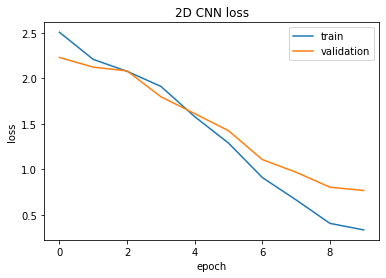

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('2D CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')